# Demonstrating the optDMD using a simple example.

Optimized Dynamic Mode Decomposition (optDMD)

Citations:

- **optimized Dynamic Mode Decomposition (optDMD)**: Askham, T., & Kutz, J. N. (2018). Variable projection methods for an optimized dynamic mode decomposition. SIAM Journal on Applied Dynamical Systems, 17(1), 380–416. https://doi.org/10.1137/M1124176

## Details

Both the optDMD and BOP-DMD were previously only matlab implementations. The focus of this notebook is the demonstration of the optDMD algorithm. optDMD provides an optimized framework for solving the DMD regressions that may come from unevenly spaced time snapshots. 

In [1]:
# netcdf/numpy/xray/stats
import numpy as np
import xarray as xr
import pandas as pd

# OS interaction
import os
import sys

# import plotting
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.dates import DateFormatter

### Quick word on warnings:

The optDMD raises several warnings. They are disabled by the below lines to make the output of the examples cleaner, but there are several points that need to be cleaned up.

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# A REALLY STUPID workaround until I make this a package.
get_directories = True
if get_directories:
    notebook_dir = os.getcwd()
    package_dir = os.path.join(notebook_dir, '../..')
    sys.path.append(package_dir)
    from py_optDMD.src import *
    get_directories = False

## Format plots

In [4]:
%matplotlib inline
# Higher resolution figures within the notebook
%config InlineBackend.figure_format = 'retina'

# Set the plot style from the seaborn library
sns.set_style("whitegrid")
sns.set_context('paper')

# Tol bright color scheme reordered to put my favorite colors first
tol_bright_reorder = [
    '#4477AA',
    '#CCBB44',
    '#EE6677',
    '#228833',
    '#66CCEE',
    '#AA3377',
    '#BBBBBB'
]
sns.set_palette(sns.color_palette(tol_bright_reorder))

# "A Simple Example"

The optDMD and the BOP-DMD are both demonstrated using the "Simple Example" from Sashidhar and Kutz (2022). Here data generated from 3 spatial modes are fit. Each mode has time dynamics which are exponential in time.

The specifics of this implementation follow from https://github.com/dsashid/BOP-DMD/blob/main/BOP_DMD_main.m

The results from the python version will be compared to the results from a similar test in matlab.

In [5]:
# Generate the synthetic data.

# Set up modes in space.
x0 = 0
x1 = 1
nx = 200

# Space component is evenly spaced originally.
xspace = np.linspace(x0,x1,nx)

# Set up the spatial modes
f1 = np.sin(xspace)[:, np.newaxis]
f2 = np.cos(xspace)[:, np.newaxis]
f3 = np.tanh(xspace)[:, np.newaxis]

# Set up the time dynamics.
t0 = 0
t1 = 1
nt = 100
ts = np.linspace(t0,t1,nt)[np.newaxis, :]

# Eigenvalues for each mode
e1 = 1 + 0j
e2 = -2 + 0j
e3 = 0 + 1j
true_eigenvalues = np.array([e1, e2, e3])

# Generate the clean, noiseless dynamics.
xclean = f1.dot(np.exp(e1 * ts)) + f2.dot(np.exp(e2 * ts)) + f3.dot(np.exp(e3 * ts))

# optDMD

Here I've finished the implementation of the python version of optDMD. This code has exactly identical versions of the optDMD output for the zero noise case and qualitatively similar outputs for added noise.

Various levels of noise, $\sigma$, are considered here for the optDMD evaluation.

The error is approximately linear with the amount of noise. i.e., a magnitude increase in $\sigma$ corresponds to almost exactly a magnitude increase in the error for this example.

**Notes**:
- The optDMD only returns real eigenvalues when providing real data (e.g., what we would normally provide when data mining). This behavior is consistent with the reference matlab code. The reference matlab code for the BOP-DMD makes reference to the eigenvalue solutions having an imaginary component, making this a confusing conundrum that needs to be resolved. 

- The `imode` keyword is not implemented. In the optDMD manuscript and reference matlab code there are several strategies presented for solving the nonlinear regression inside of the DMD. As the BOP-DMD reference code only uses the strategy `imode=0`, this keyword appears to be no longer necessary. 

## Exact case with no noise

In [6]:
# Here we explicitly specify the number of modes using r = 3.
r = 3
# imode (solution method) is not used in the python implementation.
imode = 0

# Call the optDMD and solve.
w, optdmd_e_no_noise, b,_ = optimalDMD.optdmd(xclean, ts, r, imode, verbose=False)

# Reconstruct the data.
x1 = np.dot(np.dot(w, np.diag(b)), np.exp(np.dot(optdmd_e_no_noise[:, np.newaxis], ts)))

# Determine the error of the optDMD solution.
# Note: Numpy performs the Frobenius norm by default.
relerr_r_clean = np.linalg.norm(x1 - xclean) / np.linalg.norm(xclean)

# Evaluate the optDMD solution against the actual eigenvalues by matching
# the optDMD eigenvalues to the true eigenvalues using the Munkres algorithm.
_, indices = bop_dmd.match_vectors(optdmd_e_no_noise, true_eigenvalues)
relerr_e = (
    np.linalg.norm(optdmd_e_no_noise[indices] - true_eigenvalues, 2)
    / np.linalg.norm(true_eigenvalues, 2)
)

print()
print('Exact solution without noise')
print('Relative error w.r.t clean data {:.10f}'.format(relerr_r_clean))
print('Relative error of eigenvalues {:.10f}'.format(relerr_e))
print(optdmd_e_no_noise)


Exact solution without noise
Relative error w.r.t clean data 0.0000001244
Relative error of eigenvalues 0.0000205545
[-1.99995450e+00-7.70522874e-07j  9.99990879e-01-1.03547872e-05j
  8.85045982e-06+1.00001399e+00j]


### Comparing to the MATLAB reference

This is in effect making the unit test available as an interactive example.

In [7]:
matlab_test_values = np.array(
    [
        -1.999954504915882 - 0.000000770522912j,
        0.999990878733956 - 0.000010354786854j,
        0.000008850461444 + 1.000013991908446j
    ]
)
np.testing.assert_array_almost_equal(
    optdmd_e_no_noise,
    matlab_test_values,
    decimal=7,
    verbose=True
)

## Cases with increasing levels of noise

Noise levels of $\sigma$ = 0.1, 0.01, and 0.001 are tested. For simplicity, a single realization of the noisy data is generated for each noise level. The BOP-DMD notebook includes multiple realizations of the optDMD solutions.


Example 1 results for sigma=0.001:
Relative error in reconstruction 0.0006
Relative error w.r.t clean data 0.0001
Relative error of eigenvalues 0.0047

Example 1 results for sigma=0.01:
Relative error in reconstruction 0.0059
Relative error w.r.t clean data 0.0011
Relative error of eigenvalues 0.0499

Example 1 results for sigma=0.1:
Relative error in reconstruction 0.0591
Relative error w.r.t clean data 0.0109
Relative error of eigenvalues 0.9783


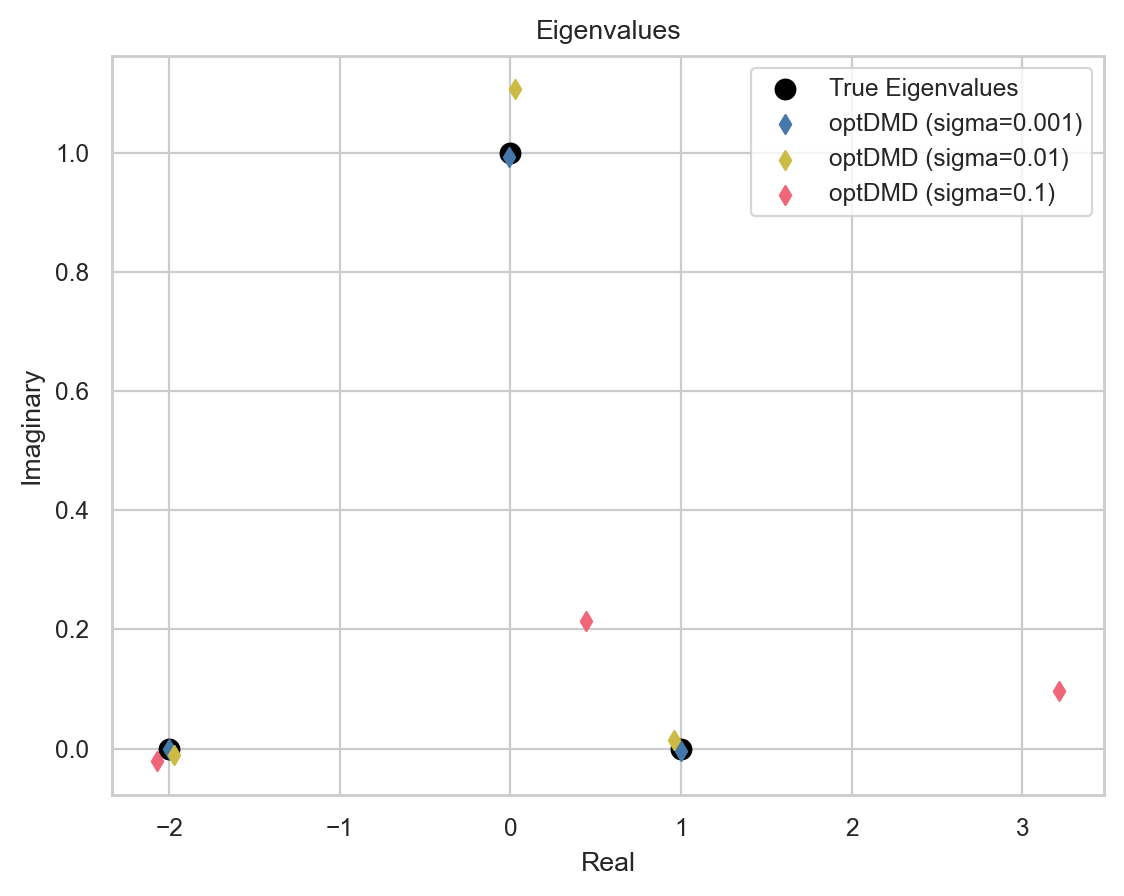

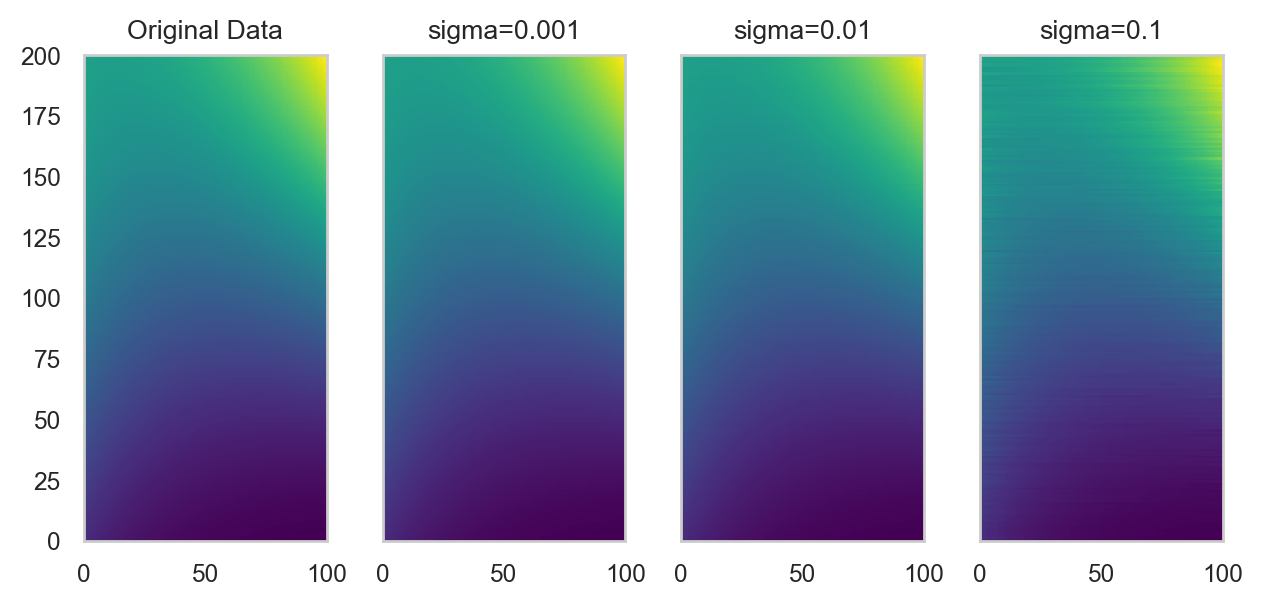

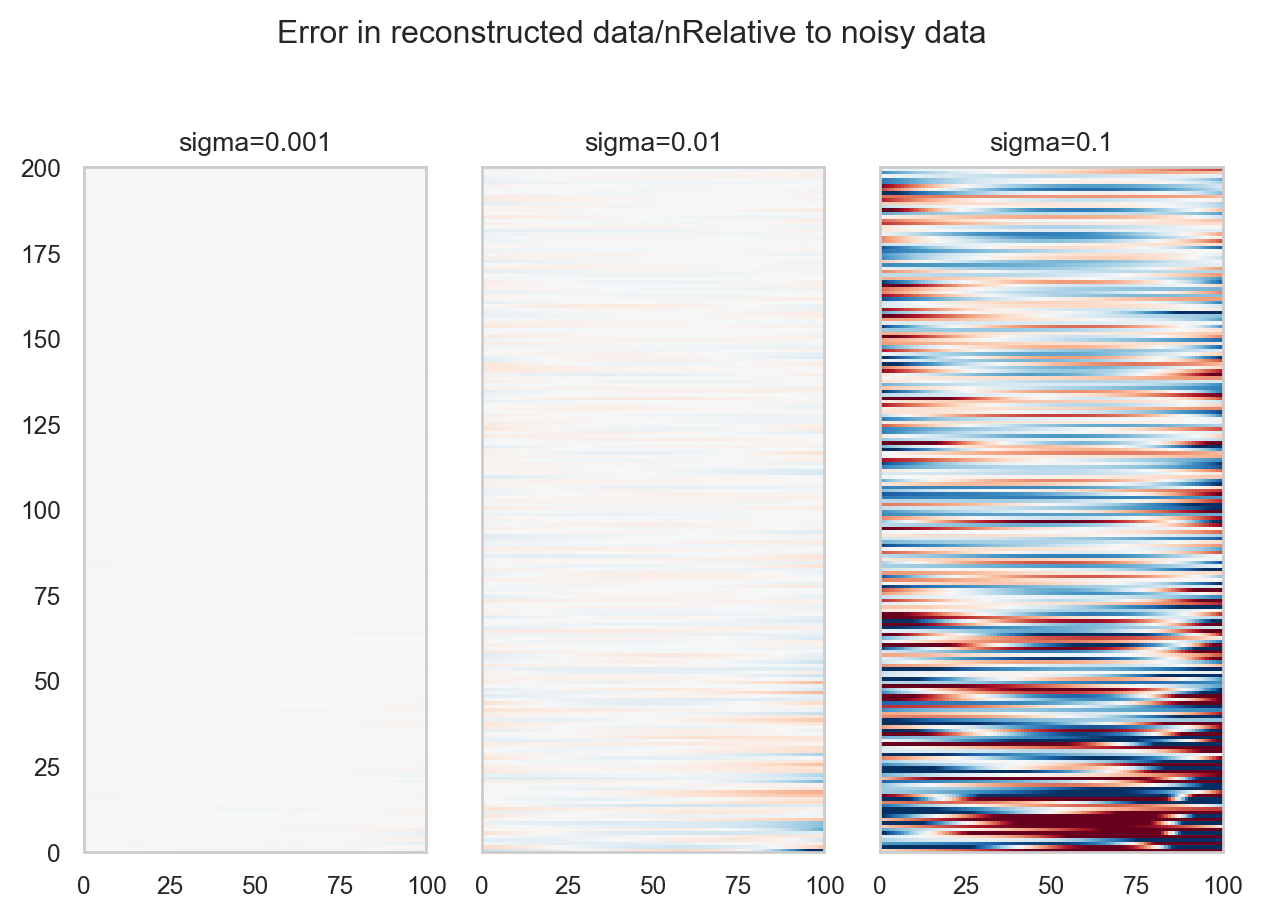

In [8]:
sigma_array = np.array([1e-3, 1e-2, 1e-1])

# Generate figure and axis handles for the evaluation plots
fig_eig_scatter, ax_eig_scatter = plt.subplots(1, 1)
fig_reconstruct, axes_reconstruct = plt.subplots(
    1, len(sigma_array) + 1, sharex=True, sharey=True
)
fig_reconstruct_error, axes_reconstruct_error = plt.subplots(
    1, len(sigma_array), sharex=True, sharey=True)

# Reconstructed data
ax = axes_reconstruct[0]
im = ax.pcolormesh(
    np.abs(xclean ** 2),
    cmap='viridis'
)
ax.set(adjustable='box', aspect='equal')
ax.set_title('Original Data')

# True eigenvalues for the eigenvalue scatter plot.
ax_eig_scatter.scatter(
    np.real(true_eigenvalues),
    np.imag(true_eigenvalues),
    50,
    color='k',
    marker='o',
    label='True Eigenvalues'
)


for nsigma, sigma in enumerate(sigma_array):
    # Add noise to the clean example data.
    # Values greater than about 0.1 lead to the whole thing failing.
    xdata = xclean + sigma * np.random.randn(*xclean.shape)
    
    # Here we explicitly specify the number of modes using r = 3.
    r = 3
    # imode (solution method) is not used in the python implementation.
    imode = 0
    
    # Call the optDMD and solve.
    w, e, b,_ = optimalDMD.optdmd(xdata, ts, r, imode, verbose=False)
    
    # Reconstruct the data.
    x1 = np.dot(np.dot(w, np.diag(b)), np.exp(np.dot(e[:, np.newaxis], ts)))

    # Determine the error of the optDMD solution.
    # Note: Numpy performs the Frobenius norm by default.
    relerr_r = np.linalg.norm(x1 - xdata) / np.linalg.norm(xdata)
    relerr_r_clean = np.linalg.norm(x1 - xclean) / np.linalg.norm(xclean)

    # Evaluate the optDMD solution against the actual eigenvalues by matching
    # the optDMD eigenvalues to the true eigenvalues using the Munkres algorithm.
    _, indices = bop_dmd.match_vectors(e, true_eigenvalues)
    relerr_e = (
        np.linalg.norm(e[indices] - true_eigenvalues, 2)
        / np.linalg.norm(true_eigenvalues, 2)
    )
    
    print()
    print('Example 1 results for sigma={}:'.format(sigma))
    print('Relative error in reconstruction {:.4f}'.format(relerr_r))
    print('Relative error w.r.t clean data {:.4f}'.format(relerr_r_clean))
    print('Relative error of eigenvalues {:.4f}'.format(relerr_e))

    # Reconstructed data error
    ax = axes_reconstruct_error[nsigma]
    im = ax.pcolormesh(
        (np.abs(xclean ** 2) - np.abs(x1 ** 2)) / np.abs(xclean ** 2),
        vmax=0.05,
        vmin=-0.05,
        cmap='RdBu_r'
    )
    ax.set(adjustable='box', aspect='equal')
    ax.set_title('sigma={}'.format(sigma))

    # Reconstructed data
    ax = axes_reconstruct[nsigma + 1]
    im = ax.pcolormesh(
        np.abs(x1 ** 2),
        cmap='viridis'
    )
    ax.set(adjustable='box', aspect='equal')
    ax.set_title('sigma={}'.format(sigma))

    # Scatterplot of eigenvalues
    ax_eig_scatter.scatter(
        np.real(e),
        np.imag(e),
        marker='d',
        label='optDMD (sigma={})'.format(sigma)
    )

# cbar = fig_reconstruct.colorbar(im)
# cbar.set_label('% Error')
fig_reconstruct_error.suptitle('Error in reconstructed data/nRelative to noisy data')
fig_reconstruct_error.tight_layout()

# fig_reconstruct.suptitle('Reconstructed data', y=1.02)
fig_reconstruct.tight_layout()

# Finish formatting the eigenvalues scatter plot.
ax_eig_scatter.legend()
ax_eig_scatter.set_ylabel('Imaginary')
ax_eig_scatter.set_xlabel('Real')
ax_eig_scatter.set_title('Eigenvalues')

fig_eig_scatter.savefig('python_optDMD.png')

Any invididual realization of the optDMD solutions for a given level of noise can vary quite substantially. Running this segment (or embedding it in a loop) will reveal something closer to the real range of values. This is done in the BOP-DMD notebook.

__Observations__:

- optDMD only generates complex eigenvalues with complex input data. The implication for real data anlaysis needs to be explained.